<a href="https://colab.research.google.com/github/SAILResearch/AI_Teammates_in_SE3/blob/main/analysis/dataset_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import annotations

"""Generate overview statistics and figures for the mined PR dataset (HF-backed)."""

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.dates as mdates
import math

# –– Nature-ready styling
mpl.rcParams.update({
    # font
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times'],
    'mathtext.fontset': 'stix',
    # axes
    'axes.linewidth': 1.0,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    # ticks
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    # legend
    'legend.fontsize': 13,
    'legend.title_fontsize': 11,
    # figure
    'figure.dpi': 300,
})
sns.set_style("whitegrid")  # subtle grid

SELECTED_AGENTS = [
    "OpenAI_Codex",
    "Devin",
    "Copilot",
    "Cursor",
    "Claude_Code",
    "Human",
]
try:
  from helper import FIG_DIR, COLOR_MAP
except Exception:
  FIG_DIR = Path("figs")
  FIG_DIR.mkdir(exist_ok=True)
  COLOR_MAP = {
    "Human": "#56B4E9",
    "OpenAI_Codex": "#D55E00",
    "OpenAI Codex": "#D55E00",
    "Codex": "#F0E442",
    "Devin": "#009E73",
    "Copilot": "#0072B2",
    "GitHub Copilot": "#0072B2",
    "Cursor": "#785EF0",
    "Claude_Code": "#DC267F",
    "Claude Code": "#DC267F",
  }

HF_ALL = "hf://datasets/hao-li/AIDev/all_pull_request.parquet"
HF_POP = "hf://datasets/hao-li/AIDev/pull_request.parquet"  # popular ones (AIDev-pop)

In [2]:

# ----------------------- Utils -----------------------
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure datetime columns are parsed and basic fields normalized."""
    df = df.copy()
    # Robust parsing (handles strings like "None" or actual None)
    for col in ["created_at", "closed_at", "merged_at"]:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce", utc=True)

    # Normalize state (lowercase)
    if "state" in df.columns:
        df["state"] = df["state"].astype(str).str.lower()

    # Ensure id is string for safe de-dup and merge logic
    if "id" in df.columns:
        df["id"] = df["id"].astype(str)

    return df


def agent_summary(df: pd.DataFrame, agent: str) -> dict:
    """Return summary stats for *agent*."""
    sub_df = df[df["agent"] == agent].drop_duplicates(subset=["id"])
    total = len(sub_df)
    open_count = (sub_df["state"] == "open").sum()
    merged_count = sub_df["merged_at"].notna().sum()
    closed_unmerged_count = ((sub_df["state"] == "closed") & (sub_df["merged_at"].isna())).sum()

    return {
        "agent": agent,
        "prs": total,
        "pct_open": open_count / total * 100 if total else 0.0,
        "pct_closed": closed_unmerged_count / total * 100 if total else 0.0,
        "pct_merged": merged_count / total * 100 if total else 0.0,
        "developers": 0 if agent in ['Copilot', 'Devin'] else sub_df["user"].nunique(dropna=True),
        "repos": sub_df["repo_url"].nunique(dropna=True),
    }


def build_summary(df: pd.DataFrame) -> pd.DataFrame:
    """Create a summary table for all selected agents present in df."""
    present = sorted(set(df["agent"].unique()) & set(SELECTED_AGENTS))
    rows = [agent_summary(df, agent) for agent in present]
    return pd.DataFrame(rows, columns=[
        "agent", "prs", "pct_open", "pct_closed", "pct_merged", "developers", "repos"
    ]).sort_values("agent")


def _nice_yticks(max_y: int):
    if max_y <= 0:
        return [0]

    round_num = int(math.log10(max_y)) - 1
    step = max(1, int(round(max_y / 5, -round_num)) or 1)
    ticks = list(range(0, max_y + step, step))
    return ticks


def plot_over_time(df: pd.DataFrame, *, cumulative: bool, fname_stub: str, title_suffix: str) -> None:
    """Plot PR trends for each agent on the provided DataFrame."""
    # Ensure datetimes exist
    if not pd.api.types.is_datetime64_any_dtype(df["created_at"]):
        raise TypeError("created_at must be datetime64[ns, tz] after preprocess().")

    agents = [a for a in SELECTED_AGENTS if a in df["agent"].unique()]
    style_map = {a: {"color": COLOR_MAP.get(a, None)} for a in agents}

    fig, ax = plt.subplots(figsize=(6, 4))
    max_y_val = 0

    for agent in agents:
        if agent == "Human":
            continue  # mirror original behavior
        sub = df[df["agent"] == agent]
        if sub.empty:
            continue
        # group by date (drop tz for grouping by date)
        dates = sub["created_at"].dt.tz_convert("UTC") if sub["created_at"].dt.tz is not None else sub["created_at"]
        grp = sub.groupby(dates.dt.date).size()
        y = grp.cumsum() if cumulative else grp
        x = pd.to_datetime(grp.index)

        max_y_val = max(max_y_val, int(y.max()) if len(y) else 0)

        ax.plot(
            x, y,
            label=agent.replace("_", " "),
            linewidth=2.2,
            **style_map[agent]
        )

    # clean up spines & grid
    for sp in ("top", "right"):
        ax.spines[sp].set_visible(False)
    ax.grid(axis="y", color="0.85", linestyle="--", linewidth=0.7)
    ax.grid(axis="x", visible=False)

    # nice monthly ticks
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    fig.autofmt_xdate(rotation=30, ha="right")

    # adaptive y ticks (fallback to your original fixed labels if large)
    if max_y_val > 0:
        yticks = _nice_yticks(max_y_val)
        ax.set_yticks(yticks)

        # compact labels like 100k
        def _fmt(v):
            if v >= 1_000_000:
                return f"{int(v / 1_000_000)}M"
            if v >= 1000:
                return f"{int(v / 1000)}k"
            return str(v)

        ax.set_yticklabels([_fmt(v) for v in yticks])

    # legend
    ax.legend(
        title="Agent",
        loc='upper left',
        frameon=True,
        ncol=1,
        fontsize=9,
        title_fontsize=10
    )

    # title/ylabel (kept minimal for paper/presentations)
    # ax.set_xlabel("Date", labelpad=6)
    # ax.set_ylabel("Cumulative PR Count" if cumulative else "Daily PR Count", labelpad=6)
    # ax.set_title(f"{'Cumulative' if cumulative else 'Daily'} PR Count — {title_suffix}", pad=10, fontsize=14)

    fig.tight_layout()
    out_pdf = FIG_DIR / f"{fname_stub}.pdf"
    out_png = out_pdf.with_suffix(".png")
    plt.show()
    fig.savefig(out_pdf, dpi=300)
    fig.savefig(out_png, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print("Wrote", out_pdf, "and", out_png)


def generate_sorted_latex_with_total(per_agent_df: pd.DataFrame, all_pr_data: pd.DataFrame) -> str:
    """
    per_agent_df: DataFrame with ['agent','prs','repos','developers','pct_*']
    all_pr_data : Raw PR rows (all PRs) to compute global totals without double counting.
    """
    # Step 1: Sort per-agent summary by 'prs' descending
    df_sorted = per_agent_df.sort_values(by='prs', ascending=False).reset_index(drop=True)

    # Step 2: Accurate global unique counts
    mask = np.logical_or(all_pr_data['agent'] == 'Copilot', all_pr_data['agent'] == 'Devin')
    all_pr_data.loc[mask, 'user'] = np.nan
    dedup = all_pr_data.drop_duplicates(subset=['id'])

    total_row = {
        'agent': 'Total',
        'prs': len(dedup),
        'developers': dedup['user'].nunique(dropna=True),
        'repos': dedup['repo_url'].nunique(dropna=True),
        'pct_open': (dedup['state'] == 'open').sum() / len(dedup) * 100 if len(dedup) else 0.0,
        'pct_merged': dedup['merged_at'].notna().sum() / len(dedup) * 100 if len(dedup) else 0.0,
        'pct_closed': (((dedup['state'] == 'closed') & dedup['merged_at'].isna()).sum()) / len(dedup) * 100 if len(
            dedup) else 0.0,
    }

    # Step 3: Append total row
    df_total = pd.concat([df_sorted, pd.DataFrame([total_row])], ignore_index=True)

    # Step 4: Format numbers
    for col in ['prs', 'repos', 'developers']:
        df_total[col] = df_total[col].apply(lambda x: f"{x:,}")
    for col in ['pct_open', 'pct_closed', 'pct_merged']:
        df_total[col] = df_total[col].apply(lambda x: f"{x:.1f}")

    df_total['agent'] = (
        df_total['agent']
        .str.replace('_popular', '', regex=False)
        .str.replace('_', ' ')
    )
    df_total.rename(
        columns={
            'agent': 'Agent',
            'prs': '\# PR',
            'repos': '\# Repository',
            'developers': '\# Developers',
            'pct_open': '\% Open PR',
            'pct_closed': '\% Closed PR',
            'pct_merged': '\% Merged PR',
        },
        inplace=True,
    )

    # Step 5: Export LaTeX table
    return df_total.to_latex(index=False, escape=False)

In [3]:
# Load from Hugging Face parquet
all_pr_df = pd.read_parquet(HF_ALL, engine="pyarrow")
pop_pr_df = pd.read_parquet(HF_POP, engine="pyarrow")  # popular subset

# Parse/normalize
all_pr_df = preprocess(all_pr_df)
pop_pr_df = preprocess(pop_pr_df)

# ---- Table: popular per-agent summary + global totals from ALL ----
all_pr_summary = build_summary(all_pr_df)
print("Summary of PRs per agent:")
print(generate_sorted_latex_with_total(all_pr_summary, all_pr_df))

popular_summary = build_summary(pop_pr_df)
print("Summary of PRs per agent (popular repos subset):")
print(generate_sorted_latex_with_total(popular_summary, pop_pr_df))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Summary of PRs per agent:
\begin{tabular}{lllllll}
\toprule
Agent & \# PR & \% Open PR & \% Closed PR & \% Merged PR & \# Developers & \# Repository \\
\midrule
OpenAI Codex & 814,522 & 6.6 & 5.8 & 87.7 & 61,653 & 84,704 \\
Copilot & 50,447 & 20.3 & 20.7 & 59.1 & 0 & 14,492 \\
Cursor & 32,941 & 21.4 & 8.0 & 70.5 & 9,658 & 12,699 \\
Devin & 29,744 & 5.6 & 29.9 & 64.4 & 0 & 4,747 \\
Claude Code & 5,137 & 7.8 & 15.4 & 76.8 & 1,643 & 1,915 \\
Total & 932,791 & 7.8 & 7.5 & 84.7 & 71,864 & 116,423 \\
\bottomrule
\end{tabular}

Summary of PRs per agent (popular repos subset):
\begin{tabular}{lllllll}
\toprule
Agent & \# PR & \% Open PR & \% Closed PR & \% Merged PR & \# Developers & \# Repository \\
\midrule
OpenAI Codex & 21,799 & 3.7 & 13.7 & 82.6 & 1,284 & 1,248 \\
Copilot & 4,970 & 21.7 & 35.3 & 43.0 & 0 & 1,012 \\
Devin & 4,827 & 3.2 & 43.0 & 53.8 & 0 & 288 \\
Cursor & 1,541 & 12.6 & 22.2 & 65.2 & 363 & 327 \\
Claude Code & 459 & 17.2 & 23.7 & 59.0 & 236 & 213 \\
Total & 33,596 & 6.9 & 2

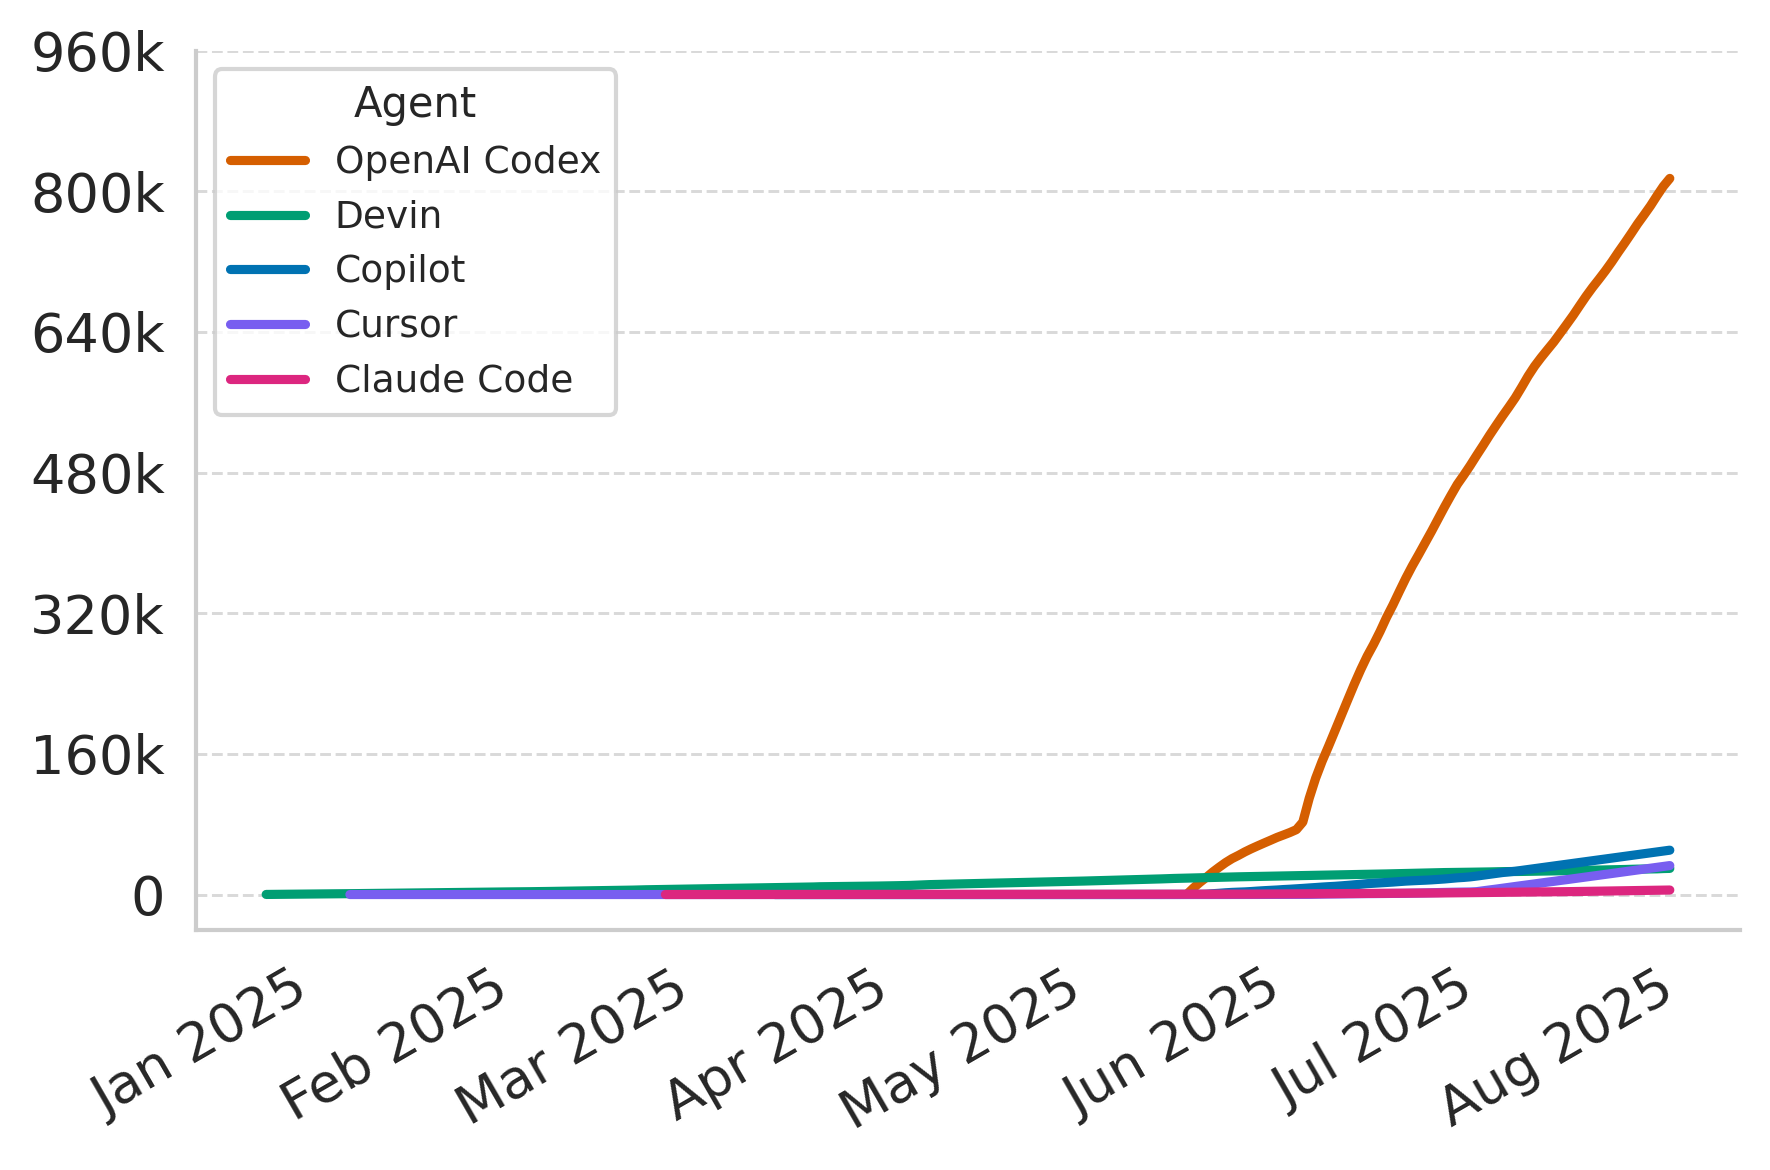

Wrote figs/pr_cumulative_all.pdf and figs/pr_cumulative_all.png


In [4]:

# ---- Figures: two cumulative plots ----
# 1) All PRs
plot_over_time(
    all_pr_df,
    cumulative=True,
    fname_stub="pr_cumulative_all",
    title_suffix="All Repositories",
)

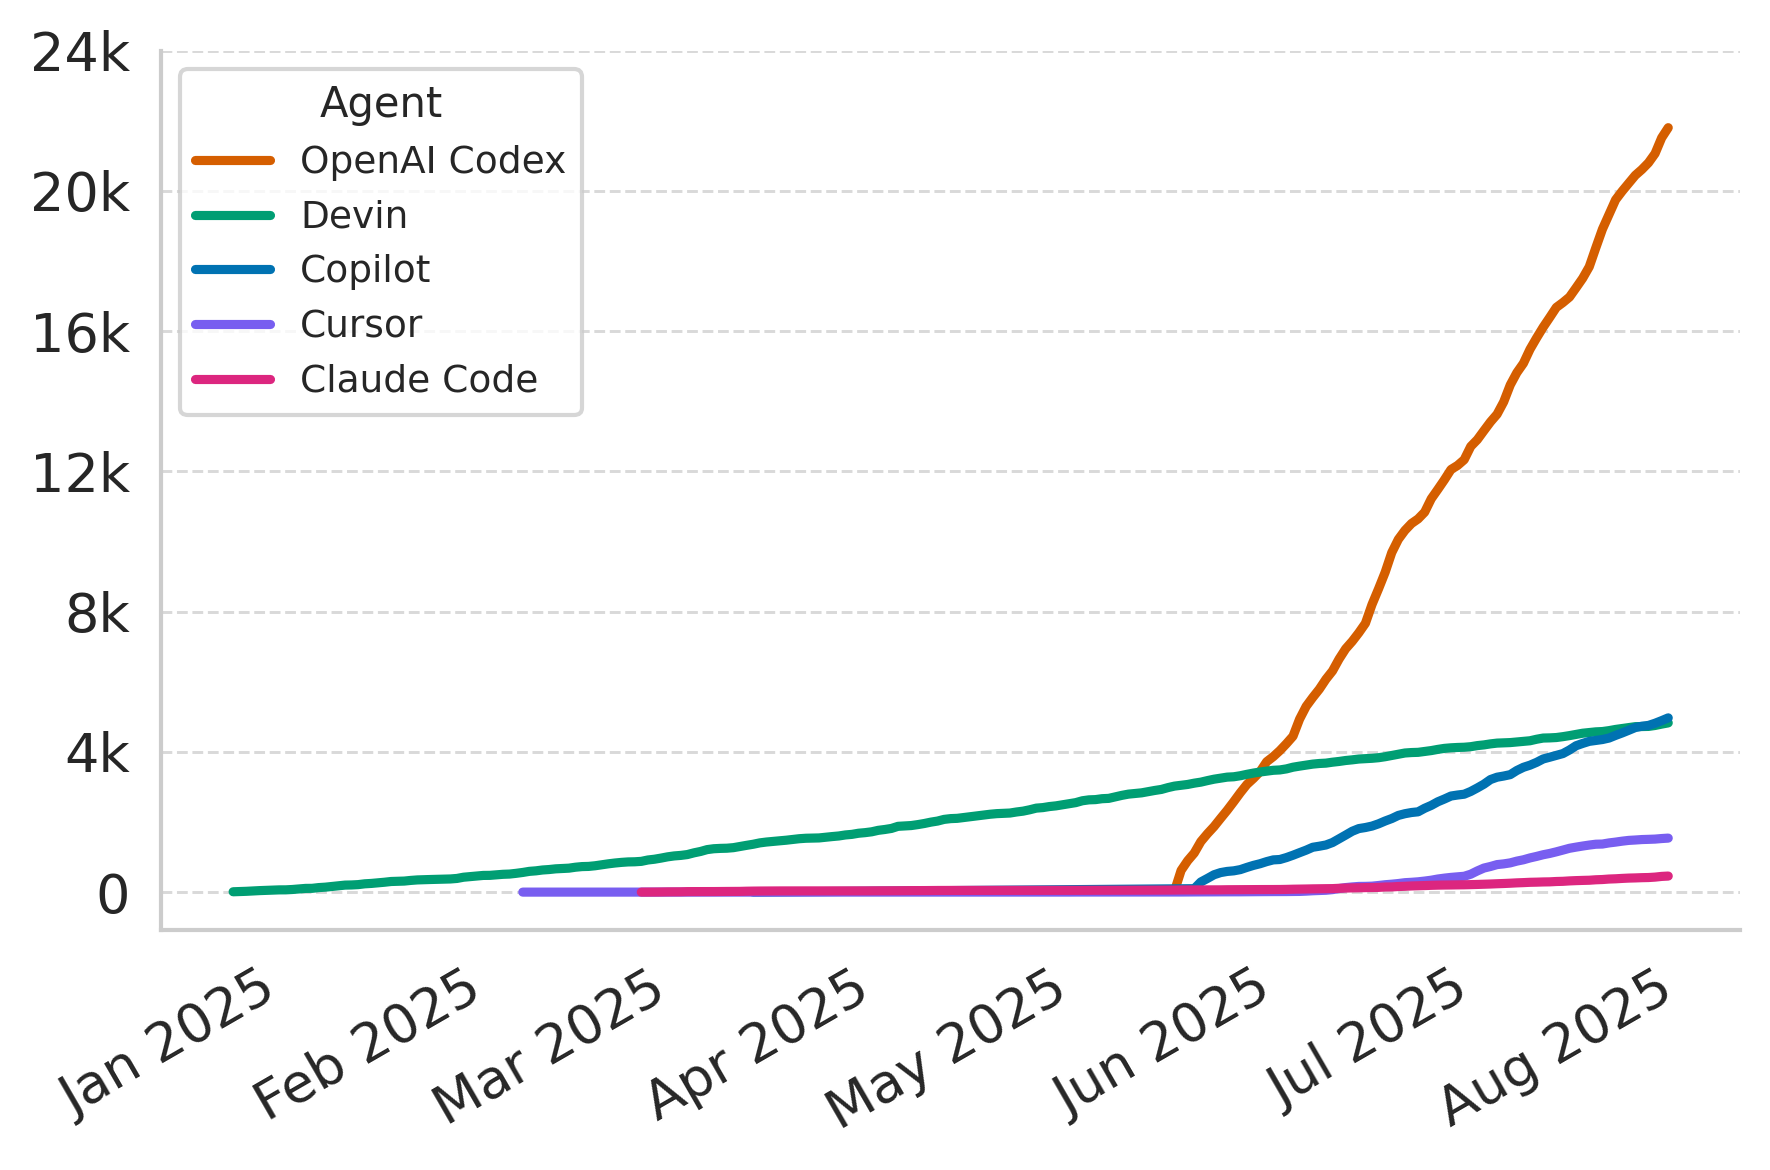

Wrote figs/pr_cumulative_popular.pdf and figs/pr_cumulative_popular.png


In [5]:
# 2) Popular-only PRs
plot_over_time(
    pop_pr_df,
    cumulative=True,
    fname_stub="pr_cumulative_popular",
    title_suffix="Popular Repositories",
)